In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
%matplotlib inline

import time
import seaborn
import matplotlib.pyplot as plt
import numpy as np
import math


from gym.envs.toy_text.frozen_lake import LEFT, RIGHT, DOWN, UP
from gym.envs.toy_text import frozen_lake, discrete, frozen_lake_robustvi

import gym
from gym.envs.registration import register


## IMPORTANT: Make sure to copy frozen_lake_robustvi.py in your local gym path
register(
    id='D-FrozenLakeRobustvi-v0',
    entry_point='gym.envs.toy_text.frozen_lake_robustvi:FrozenLakeEnvRobustVI',
    kwargs={'map_name': '8x8',
            'is_slippery': True})


def print_policy(policy, action_names):
    """ 
    Print the policy in human-readable format.
    """
    str_policy = policy.astype('str')
    for action_num, action_name in action_names.items():
        np.place(str_policy, policy == action_num, action_name)

    
    print(str_policy[0:8])
    print(str_policy[8:16])
    print(str_policy[16:24])
    print(str_policy[24:32])
    print(str_policy[32+0:32+8])
    print(str_policy[32+8:32+16])
    print(str_policy[32+16:32+24])
    print(str_policy[32+24:32+32])
    
    return str_policy

action_names = {LEFT: 'LEFT', RIGHT: 'RIGHT', DOWN: 'DOWN', UP: 'UP'}

In [2]:
env = gym.make('D-FrozenLakeRobustvi-v0')
grid = 8
gamma = 0.998 # Change this to play with it


Doing Value Iteration
Total time taken: 0.09621572494506836
Value function: [0.77829788 0.78448044 0.79402132 0.80506549 0.81694245 0.82897172
 0.83985286 0.84581968 0.77747348 0.78241011 0.79059148 0.80085431
 0.81254115 0.82550798 0.84057857 0.85169214 0.75611519 0.74331895
 0.70180354 0.         0.69931369 0.78375195 0.83719739 0.8630446
 0.72771244 0.68048958 0.58192708 0.38421239 0.5183026  0.
 0.81698458 0.8798619  0.70494783 0.58168934 0.37742492 0.
 0.45539473 0.53919638 0.74799391 0.90214119 0.6878585  0.
 0.         0.13872848 0.3235529  0.39734719 0.         0.92989639
 0.67646552 0.         0.12573941 0.08610424 0.         0.32108384
 0.         0.96316309 0.67077421 0.47683245 0.28666728 0.
 0.2601827  0.52191556 0.7597756  0.        ]
Total Value Iteration Steps: 125
Policy:
['UP' 'RIGHT' 'RIGHT' 'RIGHT' 'RIGHT' 'RIGHT' 'RIGHT' 'RIGHT']
['UP' 'UP' 'UP' 'UP' 'UP' 'UP' 'RIGHT' 'RIGHT']
['UP' 'UP' 'LEFT' 'LEFT' 'RIGHT' 'UP' 'RIGHT' 'RIGHT']
['LEFT' 'LEFT' 'UP' 'DOWN' 'LEFT'

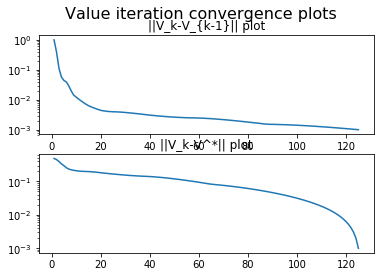

In [3]:
########################################################################
######################### Value iteration ##############################
########################################################################


def value_iteration(env, gamma, max_iterations=int(1e3), tol=1e-3):
    """
    Runs value iteration for a given gamma and environment. Return 
    the value function and the number of iterations it took to converge.
        See section 4.4 of Reinforcement Learning: An Introduction (Adaptive Computation and Machine Learning) by Sutton and Barto
    """
    value_func_old = np.random.rand(env.nS)
    value_func_new = np.zeros(env.nS)
    value_func_collect = np.zeros((env.nS,max_iterations))
    delta_collect = np.zeros(max_iterations)

    for iteration in range(max_iterations):
        delta=0
        for s in range(env.nS):
            max_value_func = -1
            
            for a in range(env.nA):
                value_func_temp=0
                for next_state_from_tpm in env.P[s][a]: 
                    prob_action = next_state_from_tpm[0]
                    cur_reward=next_state_from_tpm[2]
                    if next_state_from_tpm[3]:
                        future_reward=0
                    else: future_reward=gamma*value_func_old[next_state_from_tpm[1]]
                    value_func_temp+=prob_action * (cur_reward + future_reward)
                if value_func_temp>max_value_func:
                    max_value_func=value_func_temp
                    
            diff=abs(value_func_old[s]-max_value_func)
            delta=max(delta,diff)
            value_func_new[s]=max_value_func

        delta_collect[iteration] = delta
        value_func_old = value_func_new
        value_func_collect[:,iteration] = value_func_old
        # Stopping criteria: STOP when the sup norm of (V_k-V_{k-1}) is less than some tolerance level.
        if delta<=tol: break

    temp=np.repeat(value_func_collect[:,iteration], iteration, axis=0)
    temp=temp.reshape(grid**2,iteration)
    temp1 = abs(value_func_collect[:,0:iteration]-temp);
    distance_from_converged_value_func = temp1.max(axis=0)

    fig = plt.figure()
    fig.suptitle("Value iteration convergence plots", fontsize=16)
    ax = plt.subplot(2,1,1)
    ax.plot(range(1,iteration+1),delta_collect[0:iteration])
    ax.set_title('||V_k-V_{k-1}|| plot')
    ax.set_yscale('log')


    ax = plt.subplot(2,1,2)
    ax.plot(range(1,iteration+1),distance_from_converged_value_func)
    ax.set_title('||V_k-V^*|| plot')
    ax.set_yscale('log')

    return value_func_new, iteration


def value_function_to_policy(env, gamma, value_function):
    """
    Mapping actions for each state using the value_function to get a policy
        See section 4.4 of Reinforcement Learning: An Introduction (Adaptive Computation and Machine Learning) by Sutton and Barto
    """
    policy=np.zeros(env.nS,dtype='int')
    for s in range(env.nS):
        max_value_func=-1
        max_action=-1
        for a in range(env.nA):
            value_func_temp=0
            for next_state_from_tpm in env.P[s][a]:
                prob_action = next_state_from_tpm[0]
                cur_reward = next_state_from_tpm[2]
                future_reward = gamma * value_function[next_state_from_tpm[1]]
                value_func_temp+=prob_action * (cur_reward + future_reward)
            if value_func_temp>max_value_func:
                max_value_func=value_func_temp
                max_action=a
        policy[s]=max_action

    return policy



print("\nDoing Value Iteration")
start_time=time.time()
value_function,value_iters=value_iteration(env,gamma)
print("Total time taken: "+str((time.time()-start_time)))

print("Value function: "+str(value_function))

nonrobust_opt_v = value_function

print("Total Value Iteration Steps: "+str(value_iters))
print("Policy:")
nonrobust_policy=value_function_to_policy(env,gamma,value_function)
policy_str=print_policy(nonrobust_policy,action_names)




# l1 and chi2 ambiguity

In [4]:
from numpy import ma
from scipy.optimize import minimize

flag=input("\nEnter '1' for l1 uncertainty set or '2' for chi2 uncertainty set.\n")


if flag=="1":          


    def worstcase_l1(v,q,t):
        """
        o = worstcase_l1(v,q,t)

        Computes the solution of:
        min_p   p^T * v
        s.t.    \|p,q\|_1 <= t
        via it's Dual formulation

        where o is the objective value

        Notes
        -----

        """
        if t == 0:
            return np.dot(q,v)
        if t < 0:
            raise ValueError('Bound t must be greater than 0.')
        if q.dtype != float:
            raise ValueError('Value q must be a float array.')    

        S = len(v)

        fun = lambda x: np.dot(q,x) + (t/2) * ( np.max(v-x) - np.min(v-x) )
        cons = ({'type': 'ineq', 'fun': lambda x:  x},
    #             {'type': 'ineq', 'fun': lambda x:  v-x },
                 )
        x0 = np.random.rand(S)
    #     x0 /= np.sum(x0)

        res = minimize(fun, x0, method='SLSQP', constraints=cons,
                          tol=1e-3) #, options = {'disp': True})

        return np.dot(q,v) - res.fun
    
else:

    def worstcase_l1(v,q,t):
        """
        o = worstcase_l1(v,q,t)

        Computes the solution of:
        min_p   p^T * v
        s.t.    D_c(p,q) <= t
        via it's Dual formulation

        where o is the objective value

        Notes
        -----

        """
        if t == 0:
            return np.dot(q,v)
        if t < 0:
            raise ValueError('Bound t must be greater than 0.')
        if q.dtype != float:
            raise ValueError('Value q must be a float array.')    

        S = len(v)

        fun = lambda x: np.dot(q,x) + np.sqrt(t * ( np.dot(q,(v-x)**2) - (np.dot(q,(v-x)))**2))
        cons = ({'type': 'ineq', 'fun': lambda x:  x},
    #             {'type': 'ineq', 'fun': lambda x:  v-x },
                 )
        x0 = np.random.rand(S)
    #     x0 /= np.sum(x0)

        res = minimize(fun, x0, method='SLSQP', constraints=cons, #bounds=bnds,
                          tol=1e-3) #, options = {'disp': True})

        return np.dot(q,v) - res.fun

# Robust + Planning (with P^o and l1/chi2)


Doing Value Iteration
Total time taken: 0.6582269668579102
Value function: [0.33298555 0.33235579 0.33197441 0.33195992 0.33304659 0.33662367
 0.34445857 0.35780757 0.33195429 0.33131867 0.3309228  0.33086215
 0.33160941 0.33422232 0.34083856 0.35751484 0.29018199 0.2460183
 0.19663231 0.         0.15445079 0.22227827 0.28458698 0.35837347
 0.27612877 0.19240987 0.12404367 0.04153504 0.05674365 0.
 0.2298446  0.36271048 0.27131418 0.13708686 0.06108089 0.
 0.0330137  0.05175682 0.1620218  0.37756924 0.26957859 0.
 0.         0.00301014 0.01443756 0.0249942  0.         0.42426754
 0.26886889 0.         0.00408918 0.00161541 0.         0.02607138
 0.         0.56732458 0.26851015 0.08246722 0.02058207 0.
 0.02475151 0.09928949 0.32404043 0.        ]
Total Value Iteration Steps: 165
Policy:
['UP' 'UP' 'UP' 'UP' 'UP' 'RIGHT' 'RIGHT' 'RIGHT']
['UP' 'UP' 'UP' 'UP' 'UP' 'UP' 'UP' 'RIGHT']
['LEFT' 'UP' 'LEFT' 'LEFT' 'RIGHT' 'UP' 'RIGHT' 'RIGHT']
['LEFT' 'LEFT' 'LEFT' 'DOWN' 'LEFT' 'LEFT' 'RIG

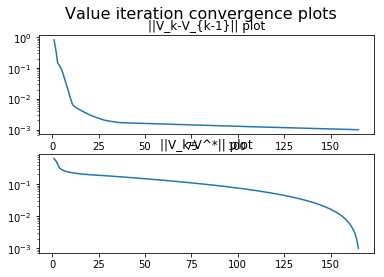

In [6]:
########################################################################
######################### Value iteration ##############################
########################################################################


def rob_plan_vi(env, gamma, max_iterations=int(1e3), tol=1e-3, c_r=0.2):
    """
    Runs value iteration for a given gamma and environment. Return 
    the value function and the number of iterations it took to converge.
    """
    value_func_old = np.random.rand(env.nS)
    value_func_new = np.zeros(env.nS)
    value_func_collect = np.zeros((env.nS,max_iterations))
    delta_collect = np.zeros(max_iterations)

    for iteration in range(max_iterations):
        delta=0
        for s in range(env.nS):
            max_value_func = -1
            
            for a in range(env.nA):
                value_func_temp=0
                z=[]
                prob_sa = []
                count_i = 0
                for next_state_from_tpm in env.P[s][a]: 
                    prob_action = next_state_from_tpm[0]
                    prob_sa.append(prob_action) # Planning with P^o
                    cur_reward=next_state_from_tpm[2]
                    if next_state_from_tpm[3]:
                        future_reward=0
                    else: future_reward=gamma*value_func_old[next_state_from_tpm[1]]
                    z.append(cur_reward + future_reward)
                    count_i+=1
                
                # Robust Bellman update
                value_func_temp = worstcase_l1(np.array(z), np.array(prob_sa), c_r)
                
                if value_func_temp>max_value_func:
                    max_value_func=value_func_temp
                    
            diff=abs(value_func_old[s]-max_value_func)
            delta=max(delta,diff)
            value_func_new[s]=max_value_func

        delta_collect[iteration] = delta
        value_func_old = value_func_new
        value_func_collect[:,iteration] = value_func_old
        # Stopping criteria: STOP when the sup norm of (V_k-V_{k-1}) is less than some tolerance level.
        if delta<=tol: break

    temp=np.repeat(value_func_collect[:,iteration], iteration, axis=0)
    temp=temp.reshape(grid**2,iteration)
    temp1 = abs(value_func_collect[:,0:iteration]-temp);
    distance_from_converged_value_func = temp1.max(axis=0)

    fig = plt.figure()
    fig.suptitle("Value iteration convergence plots", fontsize=16)
    ax = plt.subplot(2,1,1)
    ax.plot(range(1,iteration+1),delta_collect[0:iteration])
    ax.set_title('||V_k-V_{k-1}|| plot')
    ax.set_yscale('log')


    ax = plt.subplot(2,1,2)
    ax.plot(range(1,iteration+1),distance_from_converged_value_func)
    ax.set_title('||V_k-V^*|| plot')
    ax.set_yscale('log')

    return value_func_new, iteration


def rob_vf_to_policy(env, gamma, value_function, c_r=0.2):
    """
    Mapping actions for each state using the value_function to get a policy
        See section 4.4 of Reinforcement Learning: An Introduction (Adaptive Computation and Machine Learning) by Sutton and Barto
    """
    policy=np.zeros(env.nS,dtype='int')
    for s in range(env.nS):
        max_value_func=-1
        max_action=-1
        for a in range(env.nA):
            value_func_temp=0
            z=[]
            prob_sa = []
            count_i = 0
            for next_state_from_tpm in env.P[s][a]: 
                prob_action = next_state_from_tpm[0]
                prob_sa.append(prob_action)
                cur_reward=next_state_from_tpm[2]
                future_reward=gamma*value_function[next_state_from_tpm[1]]
                z.append(cur_reward + future_reward)
                count_i+=1

            value_func_temp = worstcase_l1(np.array(z), np.array(prob_sa), c_r)
            
            if value_func_temp>max_value_func:
                max_value_func=value_func_temp
                max_action=a
        policy[s]=max_action

    return policy



print("\nDoing Value Iteration")
start_time=time.time()
value_function,value_iters=rob_plan_vi(env,gamma, tol=1e-3, max_iterations=1000, c_r=0.35)
print("Total time taken: "+str((time.time()-start_time)))

print("Value function: "+str(value_function))

robust_opt_v = value_function

print("Total Value Iteration Steps: "+str(value_iters))
print("Policy:")
rob_opt_policy=rob_vf_to_policy(env,gamma,value_function, c_r=0.35)
policy_str=print_policy(rob_opt_policy,action_names)




# Robust + Learning (with \hat{P})

In [7]:
def empirical_est(s,a,n=20):
    
    ns = []
    po = []
    for tpm in env.P[s][a]:
        ns.append(tpm[1])
        po.append(tpm[0])
        
    # Generating n next states
    data = np.random.choice(range(len(ns)), n, p=po)
    
    est_p = np.zeros(len(ns))
    for i in range(len(ns)):
        est_p[i] = len(np.where(data == i)[0])*1.0/n
    
    return est_p



Doing Value Iteration
Total time taken: 0.4647810459136963
Value function: [0.36752925 0.36705301 0.36713788 0.36889941 0.37411845 0.38514222
 0.40869203 0.44790037 0.36647181 0.36597829 0.3659829  0.36711199
 0.37078642 0.37947418 0.39885899 0.4474115  0.31438347 0.26885164
 0.21662931 0.         0.17616212 0.25974744 0.3373367  0.44798247
 0.29596833 0.20790484 0.13655578 0.04646584 0.06281741 0.
 0.2720302  0.45138319 0.28966639 0.14827678 0.0667239  0.
 0.03624611 0.05521143 0.18812344 0.46369925 0.28752182 0.
 0.         0.0034925  0.01563798 0.02639524 0.         0.50239745
 0.28667147 0.         0.00504755 0.00196234 0.         0.02669573
 0.         0.62045214 0.28626735 0.09163611 0.02514216 0.
 0.02350653 0.09432283 0.3194405  0.        ]
Total Value Iteration Steps: 99
Policy:
['UP' 'UP' 'UP' 'UP' 'RIGHT' 'RIGHT' 'RIGHT' 'RIGHT']
['UP' 'UP' 'UP' 'UP' 'UP' 'UP' 'UP' 'RIGHT']
['LEFT' 'UP' 'LEFT' 'LEFT' 'RIGHT' 'UP' 'RIGHT' 'RIGHT']
['LEFT' 'LEFT' 'LEFT' 'UP' 'LEFT' 'LEFT' 'RI

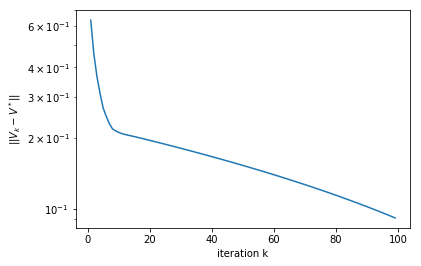

In [8]:
########################################################################
######################### Value iteration ##############################
########################################################################


def rrl_vi(env, gamma, max_iterations=int(1e3), tol=1e-3, c_r=0.2, n=20):
    """
    Runs value iteration for a given gamma and environment. Return 
    the value function and the number of iterations it took to converge.
        See section 4.4 of Reinforcement Learning: An Introduction (Adaptive Computation and Machine Learning) by Sutton and Barto
    """
    value_func_old = np.random.rand(env.nS)
    value_func_new = np.zeros(env.nS)
    value_func_collect = np.zeros((env.nS,max_iterations))
    delta_collect = np.zeros(max_iterations)
    
    # estimate transition
    transition = {s : {a : [] for a in range(env.nA)} for s in range(env.nS)}
    for s in range(env.nS):
        for a in range(env.nA):
            transition[s][a] = empirical_est(s,a,n=n)

    for iteration in range(max_iterations):
#         if not iteration%100: print("Ongoing iteration: ",iteration)
        delta=0
        for s in range(env.nS):
            max_value_func = -1
            
            for a in range(env.nA):
                value_func_temp=0
                z=[]
                prob_sa = []
                ns_prob = transition[s][a]

                count_i = 0
                for next_state_from_tpm in env.P[s][a]: 
                    # When P^o is known:
#                     prob_action = next_state_from_tpm[0]
                    # Otherwise, use empirical estimate:
                    prob_action = ns_prob[count_i]
                    prob_sa.append(prob_action)
                    
                    cur_reward=next_state_from_tpm[2]
                    if next_state_from_tpm[3]:
                        future_reward=0
                    else: future_reward=gamma*value_func_old[next_state_from_tpm[1]]
                    z.append(cur_reward + future_reward)
                    count_i+=1
                
                value_func_temp = worstcase_l1(np.array(z), np.array(prob_sa), c_r)
                
                if value_func_temp>max_value_func:
                    max_value_func=value_func_temp
                    
            diff=abs(value_func_old[s]-max_value_func)
            delta=max(delta,diff)
            value_func_new[s]=max_value_func

        delta_collect[iteration] = delta
        value_func_old = value_func_new
        value_func_collect[:,iteration] = value_func_old
        # Stopping criteria: STOP when the sup norm of (V_k-V_{k-1}) is less than some tolerance level.
        if delta<=tol: break

    temp=np.repeat(value_func_collect[:,iteration], iteration, axis=0)
    temp=temp.reshape(grid**2,iteration)
    temp1 = abs(value_func_collect[:,0:iteration]-temp);
    distance_from_converged_value_func = temp1.max(axis=0)

#     fig = plt.figure()
#     fig.suptitle("Value iteration convergence plots", fontsize=16)
#     ax = plt.subplot(3,1,1)
#     ax.plot(range(1,iteration+1),delta_collect[0:iteration])
#     ax.set_title('||V_k-V_{k-1}|| plot')
#     ax.set_yscale('log')


#     ax = plt.subplot(3,1,2)
#     ax.plot(range(1,iteration+1),distance_from_converged_value_func)
#     ax.set_title('||V_k-V^*|| plot')
#     ax.set_yscale('log')
    
    temp=np.repeat(robust_opt_v, iteration, axis=0)
    temp=temp.reshape(grid**2,iteration)
    temp1 = abs(value_func_collect[:,0:iteration]-temp);
    v_k_robopt_diff = temp1.max(axis=0)
    
#     ax = plt.subplot(1,1,1)
#     ax.plot(range(1,iteration+1),v_k_robopt_diff)
#     ax.set_ylabel(r'\|V_k-V^*\|')
#     ax.set_xlabel('iteration k')
#     ax.set_yscale('log')

#     plt.figure()
    plt.plot(range(1,iteration+1),v_k_robopt_diff)
    plt.ylabel(r'$||V_k-V^*||$')
    plt.xlabel('iteration k')
    plt.yscale('log')

#     #### LEARNING CURVE save data
#     np.savetxt('FL_l1_cr_0.35_learning.csv', (range(1,iteration+1), v_k_robopt_diff),\
#                                    delimiter=',')

    
    temp1 = abs(value_func_collect[:,-1]-robust_opt_v);
    lastvk_robopt_diff = temp1.max(axis=0)

    return value_func_new, iteration, lastvk_robopt_diff, approx_vf_to_policy(env,gamma,value_func_new, transition, c_r=c_r, n=n)


def approx_vf_to_policy(env, gamma, value_function, transition, c_r=0.2, n=20):
    """
    Mapping actions for each state using the value_function to get a policy
        See section 4.4 of Reinforcement Learning: An Introduction (Adaptive Computation and Machine Learning) by Sutton and Barto
    """
    policy=np.zeros(env.nS,dtype='int')
    for s in range(env.nS):
        max_value_func=-1
        max_action=-1
        for a in range(env.nA):
            value_func_temp=0
            z=[]
            prob_sa = []
            ns_prob = transition[s][a]
            count_i = 0
            for next_state_from_tpm in env.P[s][a]: 
                # When P^o is known:
#               prob_action = next_state_from_tpm[0]
                # Otherwise, use empirical estimate:
                prob_action = ns_prob[count_i]
                prob_sa.append(prob_action)
                cur_reward=next_state_from_tpm[2]
                future_reward=gamma*value_function[next_state_from_tpm[1]]
                z.append(cur_reward + future_reward)
                count_i+=1

            value_func_temp = worstcase_l1(np.array(z), np.array(prob_sa), c_r)
            
            if value_func_temp>max_value_func:
                max_value_func=value_func_temp
                max_action=a
        policy[s]=max_action

    return policy

print("\nDoing Value Iteration")
start_time=time.time()
value_function,value_iters,_,approx_rob_policy=rrl_vi(env,gamma, max_iterations=int(100), tol=1e-3, c_r=0.35, n=5000)
print("Total time taken: "+str((time.time()-start_time)))

print("Value function: "+str(value_function))

print("Total Value Iteration Steps: "+str(value_iters))



print("Policy:")
policy_str=print_policy(approx_rob_policy,action_names)


# Performance N curve

seed -  0
seed -  1
seed -  2
seed -  3
seed -  4
seed -  5
seed -  6
seed -  7
seed -  8
seed -  9


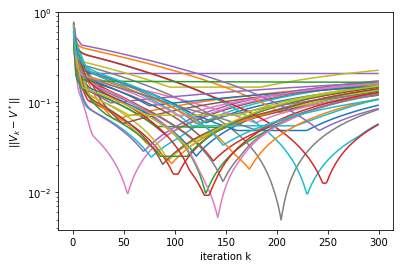

In [9]:
n_range = [50, 1000, 3000, 5000]

s_range = range(10)
diff_seeds = np.zeros((len(s_range),len(n_range)))
pol_seed = []
for s in s_range:
    print("seed - ", s)
    env.seed(s)
    diff_values = []
    pol = []
    for n in n_range:
        np.random.seed(int(s+n))
        _,_,diff,temp_pol = rrl_vi(env,gamma, max_iterations=int(300), tol=1e-4, c_r=0.35, n=int(n)) # for N curve
        diff_values.append(diff)
        pol.append(temp_pol)
    diff_seeds[s,:] = diff_values
    pol_seed.append(pol)
    

[[0.14915988 0.1596388  0.12558949 0.14671802]
 [0.20928863 0.16413717 0.16746295 0.08391729]
 [0.22783855 0.16407858 0.13986763 0.12579856]
 [0.1328142  0.12561664 0.17371796 0.12030439]
 [0.12603252 0.12512216 0.13770817 0.05825486]
 [0.09354145 0.14181777 0.14987539 0.05716022]
 [0.16593497 0.1538843  0.12386509 0.12766807]
 [0.15517772 0.10844568 0.15089242 0.10975082]
 [0.16719689 0.12926053 0.0857947  0.14200353]
 [0.16431943 0.12235732 0.15197601 0.10788848]]


Text(0,0.5,'value diff')

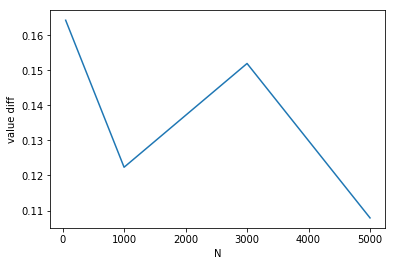

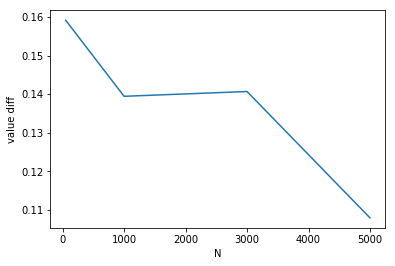

In [11]:
plt.figure()
plt.plot(n_range,diff_values)
plt.xlabel("N")
plt.ylabel("value diff")

print(diff_seeds)

plt.figure()
plt.plot(n_range,np.mean(diff_seeds,axis=0))
plt.xlabel("N")
plt.ylabel("value diff")

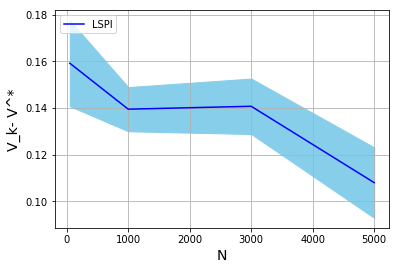

In [18]:
plt.figure()
mean_vals = np.mean(diff_seeds,axis=0)
std_vals = np.std(diff_seeds,axis=0)
plt.plot(n_range,mean_vals, color='b', label='LSPI')
plt.fill_between(n_range, mean_vals - 0.5*std_vals, mean_vals + 0.5*std_vals, color='skyblue' )
plt.xlabel("N",fontsize=14)
plt.ylabel("V_k- V^*",fontsize=14)
plt.legend(loc = 'upper left')
plt.grid()

In [19]:
# Uncomment this if you want to save data
# np.savetxt('FL_l1_cr_0.35_N.csv', (n_range, mean_vals, std_vals),\
#                                    delimiter=',')

# Performance of Robust vs non-robust policies

In [13]:
def run_policy_for_t(env, gamma, policy, p):
    initial_state = env.reset()
#     env.render()
    current_state = initial_state
    t = 1 
    while True:
        if np.random.uniform() < p:
            nextstate, reward, done, debug_info = env.step(np.random.randint(env.nA),0)
        else:
            nextstate, reward, done, debug_info = env.step(policy[int(current_state)],0)
#         env.render()

        if t > 500 or done:
            break

        current_state=nextstate
        t += 1
    
    return reward

In [14]:

perturb_p = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
    
n_runs = 1000

    
s_range = range(10)
win_ratio_seeds = np.zeros((len(s_range),len(perturb_p),2+len(n_range)))
for s in s_range:
    print("seed - ", s)
    policies = []
    # non-robust opt
    policies.append( nonrobust_policy )
    # robust opt l1
    policies.append( rob_opt_policy_temp )
    # robust policies for N samples in n_range 
    for j, _ in enumerate(n_range):
        policies.append( pol_seed[s][j] )
    win_percent_data = []
    for jj, p in enumerate(perturb_p):
        data_collect = []
        time_data_collect = []
        for n in range(n_runs):
            np.random.seed(np.random.randint(s+n+10))
            temp = []
            for j in range(len(policies)):
                temp.append(run_policy_for_t(env, gamma, policies[j], p))
            data_collect.append(temp)

        win_percent = np.mean(data_collect, axis=0)
#         print(p)
#         print('winning percent: ')
#         print(win_percent)
#         print('*'*40)
        win_ratio_seeds[s,jj,:] = win_percent

seed -  0
seed -  1
seed -  2
seed -  3
seed -  4
seed -  5
seed -  6
seed -  7
seed -  8
seed -  9


In [16]:
mean_vals = np.mean(win_ratio_seeds,axis=0)
std_vals = np.std(win_ratio_seeds,axis=0)

# Note-to-self: High time I learn using panda!
perturb_p_with_mean_vals = np.zeros((mean_vals.shape[0],mean_vals.shape[1]+1))
perturb_p_with_mean_vals[:,0:mean_vals.shape[1]] = mean_vals
perturb_p_with_mean_vals[:,-1] = perturb_p

perturb_p_with_std_vals = np.zeros((mean_vals.shape[0],mean_vals.shape[1]+1))
perturb_p_with_std_vals[:,0:mean_vals.shape[1]] = std_vals
perturb_p_with_std_vals[:,-1] = perturb_p
# print(perturb_p_with_mean_vals)
# print(perturb_p_with_std_vals)


# Uncomment this if you want to save data
# np.savetxt('FL_l1_cr_0.35_test_performance.csv', (perturb_p_with_mean_vals.reshape(-1), perturb_p_with_std_vals.reshape(-1)),\
#                                    delimiter=',')

[[0.9565 0.9994 0.9909 0.9994 0.9995 0.8994 0.    ]
 [0.5359 0.6825 0.6378 0.6481 0.6319 0.5996 0.1   ]
 [0.2908 0.3975 0.3602 0.3733 0.3571 0.345  0.2   ]
 [0.1486 0.2141 0.1886 0.1998 0.1879 0.1814 0.3   ]
 [0.0747 0.1121 0.1008 0.1047 0.0951 0.0959 0.4   ]
 [0.0399 0.0543 0.0531 0.0534 0.0549 0.0536 0.5   ]]
[[0.00777496 0.00091652 0.01854966 0.00066332 0.00067082 0.29980067
  0.        ]
 [0.01056835 0.01830437 0.04247305 0.02843396 0.02906699 0.17290703
  0.1       ]
 [0.01366602 0.01533134 0.03394643 0.02978943 0.02893942 0.09459704
  0.2       ]
 [0.0102     0.01078378 0.02323015 0.01675589 0.01626315 0.04632753
  0.3       ]
 [0.00948736 0.0069491  0.00958958 0.00988989 0.00648768 0.02326564
  0.4       ]
 [0.00472123 0.0059     0.00723118 0.00795236 0.00747596 0.01455472
  0.5       ]]
